In [145]:
import pandas as pd
from scipy.interpolate import interp1d
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import price_data as price
import statistics
import time
from datetime import date

def find_start(data):
    start_found=False
    timestamps=data['unix']
    index=len(timestamps)-1
    while not(start_found):
        day=date.fromtimestamp(timestamps.iloc[index]).weekday()
        if day==0:
            start_found=True
        else:
            index=index-1
    return timestamps.iloc[index]

def read_data(filename):
    raw=pd.read_csv('data/'+filename)
    start=find_start(raw)
    trimmed=raw.loc[raw['unix']>=start]
    return trimmed.sort_values(by=['unix'], ignore_index=True)

btc_price_data=read_data('Bitstamp_BTCUSD_d.csv')
weekly_candles=price.get_price_data('1w',data=btc_price_data)
# candles=[]
# for i in reversed(range(len(btc_price_data))):
#     candle=btc_price_data.iloc[i]
#     candles.append((candle['unix'],candle['open'], candle['high'],candle['low'], candle['close']))

In [218]:
def get_sma(data,window):
     #using daily for now
    timestamps=data['unix'][window-1:]
    sma=data.rolling(window).mean()['close'].dropna()
    return pd.DataFrame({'unix': timestamps,'value':sma})

    # return pd.DataFrame({'unix': list(map(lambda x: x[0], sma)),'value':list(map(lambda x: x[1], sma))})

def get_ema(data,window):
    timestamps=data['unix'][window:]
    ema=data.ewm(span=window,min_periods=window+1, adjust=False).mean()['close'].dropna()
    return pd.DataFrame({'unix': timestamps,'value':ema})

def risk_indicator(fast,slow):
    start_date=slow['unix'].min()
    trimmed_fast=fast.loc[fast['unix']>=start_date]

    if len(trimmed_fast)>len(slow):
        #different values, ie using a daily for fast and weekly for slow
        print(trimmed_fast['unix'].max()-slow['unix'].max())
        f=interp1d(slow['unix'],slow['value'])
        slow_interpolated=f(trimmed_fast['unix'])
        slow=pd.DataFrame({'unix':trimmed_fast['unix'],'value':slow_interpolated})

    if ('close' in fast.columns.values.tolist()):
        #using price
        risk_metric=np.divide(trimmed_fast['close'],slow['value'])
    else:
        #using moving average
        risk_metric=np.divide(trimmed_fast['value'],slow['value'])

    mean=np.mean(risk_metric)
    sigma=np.std(risk_metric)
    normalised=(risk_metric-mean)/sigma
    risk=norm.cdf(normalised)
    return pd.DataFrame({'unix':trimmed_fast['unix'],'value':risk})



In [216]:
fast=get_sma(btc_price_data,50)
fast_ema=get_ema(btc_price_data,50)
slow=get_sma(weekly_candles,50)



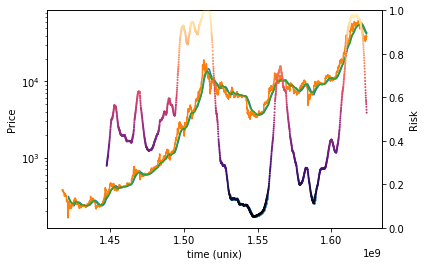

In [210]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('time (unix)')
ax1.set_ylabel('Price')
timestamps=fast['unix']
ax1.plot(fast['unix'],fast['value'])

risk=risk_indicator(fast,slow)
ax1.plot(btc_price_data['unix'],btc_price_data['close'])
ax1.plot(fast_ema['unix'],fast_ema['value'])
ax1.set_yscale('log')

ax2 = ax1.twinx()
ax2.set_ylabel('Risk')
filtered_risk=risk.loc[risk['value']<0.15]
ax2.scatter(filtered_risk['unix'],filtered_risk['value'], s=1)
ax2.set_ylim(0,1)
#ax2.vlines(filtered_risk['unix'],0,btc_price_data['close'].max(), colors='r')

ax2.scatter(risk['unix'],risk['value'], s=1, c=risk['value'], cmap='magma')

(0.0, 1.0)

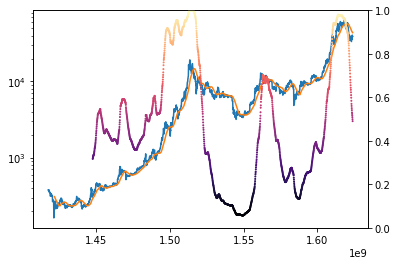

In [211]:

fig2, ax3 = plt.subplots()
ax3.plot(btc_price_data['unix'],btc_price_data['close'])
ax3.plot(fast['unix'],fast['value'])
risk2= risk_indicator(fast_ema,slow)
filtered_risk=risk2.loc[risk2['value']<0.2]
ax3.set_yscale('log')
ax4 = ax3.twinx()
ax4.scatter(risk2['unix'],risk2['value'], s=1, c=risk2['value'], cmap='magma')
ax4.set_ylim(0,1)
# ax4.vlines(filtered_risk['unix'],0,btc_price_data['close'].max(), colors='r')

In [217]:
def exponentially_weighted_risk(fast,slow):#places more weight on recent values to calculate the mean and standard deviation
    start_date=slow['unix'].min()
    trimmed_fast=fast.loc[fast['unix']>=start_date]

    if len(trimmed_fast)>len(slow):
        #different values, ie using a daily for fast and weekly for slow
        f=interp1d(slow['unix'],slow['value'])
        slow_interpolated=f(trimmed_fast['unix'])
        slow=pd.DataFrame({'unix':trimmed_fast['unix'],'value':slow_interpolated})

    if ('close' in fast.columns.values.tolist()):
        #using price
        risk_metric=np.divide(trimmed_fast['close'],slow['value'])
    else:
        #using moving average
        risk_metric=np.divide(trimmed_fast['value'],slow['value'])

    df=pd.DataFrame({'unix':trimmed_fast['unix'],'risk_metric':risk_metric})
    df.dropna(inplace=True)
    n=len(df)
    mean=df.ewm(span=n,min_periods=n,adjust=False).mean()
    sigma=df.ewm(span=n,min_periods=n,adjust=False).std()

    mean.dropna(inplace=True)
    mean=mean.head(1)['risk_metric']
    sigma.dropna(inplace=True)
    sigma=sigma.head(1)['risk_metric']
    
    mean=np.mean(risk_metric)
    sigma=np.std(risk_metric)
    normalised=(risk_metric-mean)/sigma
    risk=norm.cdf(normalised)

    df['value']=risk
    return df
    # return df


exponentially_weighted_risk(fast,slow)

,unix,risk_metric,value
349,1447545600,1.109756,0.285532
350,1447632000,1.117983,0.290736
351,1447718400,1.126025,0.295864
352,1447804800,1.134376,0.301233
353,1447891200,1.141813,0.306051
...,...,...,...
2386,1623542400,1.522706,0.578793
2387,1623628800,1.509279,0.569037
2388,1623715200,1.492414,0.556724
2389,1623801600,1.473816,0.543083


In [237]:
month_dictionary={
    'Jan':1,
    'Feb':2,
    'Mar':3,
    'Apr':4,
    'May':5,
    'Jun':6,
    'Jul':7,
    'Aug':8,
    'Sep':9,
    'Oct':10,
    'Nov':11,
    'Dec':12,
}

def parse_data(datestring):
    string=datestring.split('-')
    month=month_dictionary[string[0]]
    day=int(string[1])
    year=int(string[2])
    d=date(year,month,day)

    return int(time.mktime(d.timetuple()))
    


0


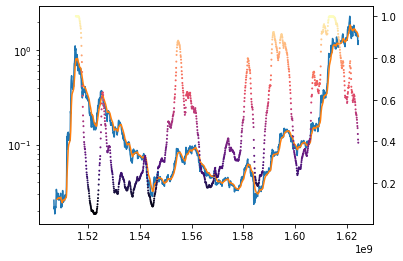

In [240]:
def process_coincodex_csv(filename):

    raw_data=pd.read_csv('data/'+filename)
    vectorised_parsing=np.vectorize(parse_data)
    timestamps=vectorised_parsing(cardano_raw_data['Date'].values)
    df=raw_data

    df['unix']=timestamps
    df.columns = ['date','open','high','low','close','volume','market cap','unix']
    df.sort_values(by='unix', ignore_index=True, inplace=True)

    return df

cardano_weekly=price.get_price_data('1w',data=cardano)

fig3, ax5 = plt.subplots()

cardano_fast=get_ema(cardano,14)
cardano_slow=get_sma(cardano_weekly,14)
ax5.plot(cardano['unix'], cardano['close'])
ax5.plot(cardano_fast['unix'], cardano_fast['value'])
cardano_risk=risk_indicator(cardano_fast,cardano_slow)
ax6 =ax5.twinx()
ax6.scatter(cardano_risk['unix'],cardano_risk['value'], s=1, c=cardano_risk['value'], cmap='magma')
ax5.set_yscale('log')